## Libraries

In [1]:
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
import statsmodels.stats as sms
import statsmodels.api as sm
import seaborn as sn
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.stats.descriptivestats as smss
import requests
import scipy.optimize as scpo
import math

# Crypto portfolio

1. Crypto - Data: load and describe
2. Crypto - Data processing and exploratory analysis
3. Crypto - Portfolio construction
-----

## 1.Crypto - Data: load and describe
From the top 20 cryptocurrencies we removed the following: 
- Stablecoins DAI, USDC, USDT, DAI, BUSD, UST.
- "Shitcoins" Dogecoin (DOGE) and Shiba Inu (SHIB) in order to focus on projects with a real intrinsic value. 
- Ripple (XRP), Ripple Lab (the company behind XRP) is facing a lawsuit against the SEC, this situation is affecting too much the coin's performances and its future.
- Wrapped Bitcoin (WBTC), WBTC is just a Bitcoin's derivative and then it would be useless to keep it inside our analysis.
- Polkadot (DOT), Solana(SOL) and Avalanche (AVAX), their timeframes were too short and not consistent with the kind of analysis we wanted to perform.

The selected batch is Bitcoin(BTC), Ethereum(ETH), Cardano(ADA), Binance Coin(BNB), Luna(LUNA), Polygon (MATIC) and Cronos(CRO).

To make further selection we decide to analyse each currency's ecosystem in order to select just the projects with the healtier ecosystem. As discriminant we used the Total value locked in $USD in each DeFi ( Decentralized Finance) ecosystem. We took this data from DeFillama which is one of the most prominent data provider regarding the blockchain world. We didn't include BTC and ETH in this process because it wasn't necessary to analyse their ecosystem since they're well established and proven.

In [2]:
defi_cardano=pd.read_csv('/Users/matteomamino/Desktop/Crypto/defi_cardano.csv').rename(columns={'Protocol':'Chain'})
defi_binance=pd.read_csv('/Users/matteomamino/Desktop/Crypto/defi_binance.csv').rename(columns={'Protocol':'Chain'})
defi_luna=pd.read_csv('/Users/matteomamino/Desktop/Crypto/defi_luna.csv').rename(columns={'Protocol':'Chain'})
defi_polygon=pd.read_csv('/Users/matteomamino/Desktop/Crypto/defi_polygon.csv').rename(columns={'Protocol':'Chain'})
defi_cro=pd.read_csv('/Users/matteomamino/Desktop/Crypto/defi_cro.csv').rename(columns={'Protocol':'Chain'})

defi_cardano.set_index('Chain', inplace= True)
defi_binance.set_index('Chain', inplace= True)
defi_luna.set_index('Chain', inplace= True)
defi_polygon.set_index('Chain', inplace= True)
defi_cro.set_index('Chain', inplace= True)

deficardano = defi_cardano.rename(index={'Total':'ADA'})
deficardano2= deficardano[0:1]
defibinance = defi_binance.rename(index={'Total':'BNB'})
defibinance2= defibinance[0:1]
defiluna = defi_luna.rename(index={'Total':'LUNA'})
defiluna2= defiluna[0:1]
defimatic = defi_polygon.rename(index={'Total':'MATIC'})
defimatic2= defimatic[0:1]
deficro = defi_cro.rename(index={'Total':'CRO'})
deficro2= deficro[0:1]


tvl = pd.concat([deficardano2, defibinance2, defiluna2, defimatic2, deficro2])
tvl_ready= tvl[['28/02/2022']].rename(columns={'28/02/2022':'TotalValueLocked'})

----
## 2. Crypto - Data processing and exploratory analysis
- Ecosystem analysis
- Retrieve data
- Compute returns, log returns, mean returns
- Test for the mean equal to zero
- Check the correlation

----

#### Ecosystem analysis
We removed the 2 cryptos with the least total value locked inside their ecosystem, Cardano(ADA) and Cronos (CRO).

In [3]:
threshold = tvl_ready.TotalValueLocked.quantile(0.4)

In [4]:
#we selected the 3 blockchains with most total value locked inside their defi ecosystem
tvl_ready[(tvl_ready.TotalValueLocked > threshold)]

,TotalValueLocked
Chain,
BNB,1.171305e+10
LUNA,1.961501e+10
MATIC,3.855350e+09


#### Retrieve data
We retrieve the data of the selected cryptos.

In [5]:
#we remove XRP, DOGE, SHIB
#starting from 2014
tickers = ['BTC-USD','ETH-USD','BNB-USD','LUNA1-USD','MATIC-USD']
end = '31/12/2021'

dfs=[]
col = ['adjclose']

for ticker in tickers:
    frame = si.get_data(ticker)[col].rename(columns={'adjclose':ticker})
    _frame= frame.loc[(frame.index<end)].copy()
    dfs.append(_frame)

df1 = pd.concat(dfs,axis = 1).dropna()

#### Compute returns, log returns, mean returns

In [6]:
#Return
dfs2=[]

for ticker in df1:
    frame2 = df1.pct_change(axis=0)
    dfs2.append(frame2)
    if ticker == 'BTC-USD':
        break
    
ret2= pd.concat(dfs2,axis=1).dropna()

#Logret

log_ret2=np.log(ret2+1)
logret_mean= log_ret2.mean()

#test the mean equal to zero

dfstat2={}
for ticker in log_ret2:
    z2=np.zeros(len(ticker))
    x2=sms.weightstats.ttest_ind(log_ret2[ticker],z2,value=0)
    dfstat2[ticker]=x2
    
logret_mean=pd.DataFrame(logret_mean)

#### Check the correlation
We checked the correlation in order to mitigate our portfolio volatility. This analysis showed us a strong correlation between BTC and ETH, and between BNB and ETH.

In [7]:
log_ret2.corr()

,BTC-USD,ETH-USD,BNB-USD,LUNA1-USD,MATIC-USD
BTC-USD,1.000000,0.817789,0.697289,0.437972,0.549944
ETH-USD,0.817789,1.000000,0.725361,0.463081,0.602839
BNB-USD,0.697289,0.725361,1.000000,0.430570,0.594993
LUNA1-USD,0.437972,0.463081,0.430570,1.000000,0.372057
MATIC-USD,0.549944,0.602839,0.594993,0.372057,1.000000


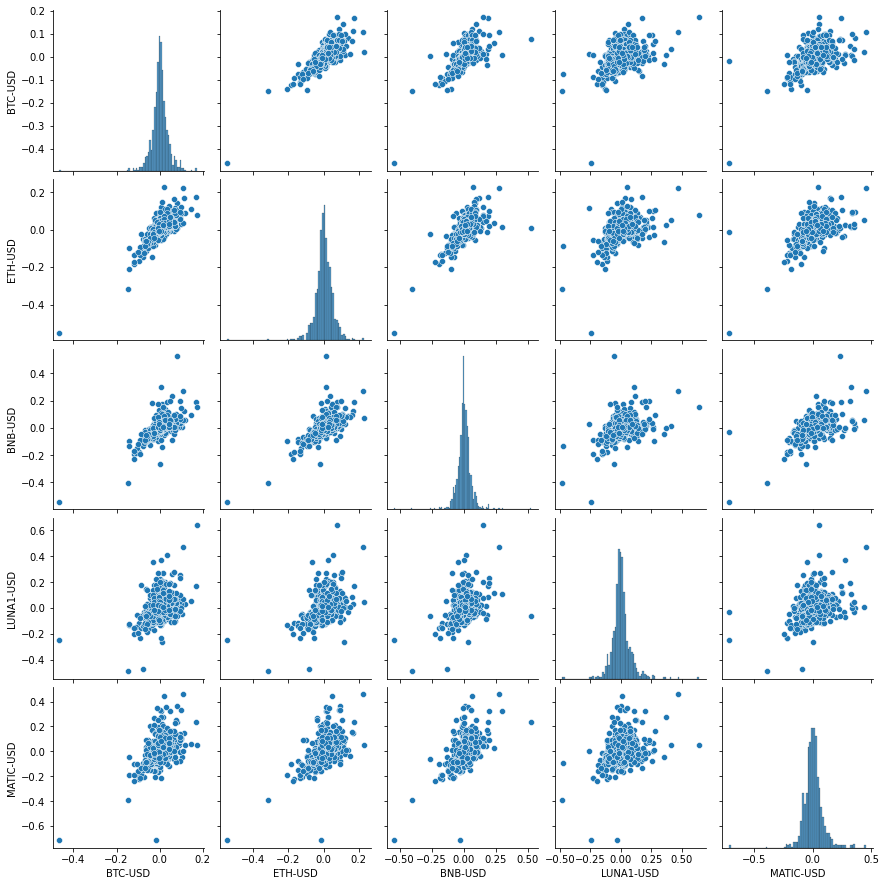

In [8]:
sn.pairplot(log_ret2)

-----
## 3.Crypto - Portfolio construction

- Compute annualized mean and annualized volatility
- Determine random weights
- Compute and optimize the sharpe ratio
- Optimal crypto portfolio
- Determine our stock portfolio mean return

-----

#### Compute annualized mean and annualized volatility

In [9]:
def compute_return(weight, df1):
    mean= np.sum(df1.mean()*252*weight)
    return mean

def compute_vol(weight, df1):
    covar=df1.cov()*252
    var=weight.T@covar@weight
    vol=np.sqrt(var)
    return vol

#### Determine random weights

In [10]:
#simulation
N=5000
asset=log_ret2.shape[1]

rets=[]
vols=[]

np.random.seed(20)


for p in range (N):
    weight=np.random.random_sample(asset)
    weight /= np.sum(weight)
    ret=compute_return(weight, log_ret2)
    rets.append(ret)
    vol= compute_vol(weight, log_ret2)
    vols.append(vol)
    
rets= np.array(rets)
vols= np.array(vols)

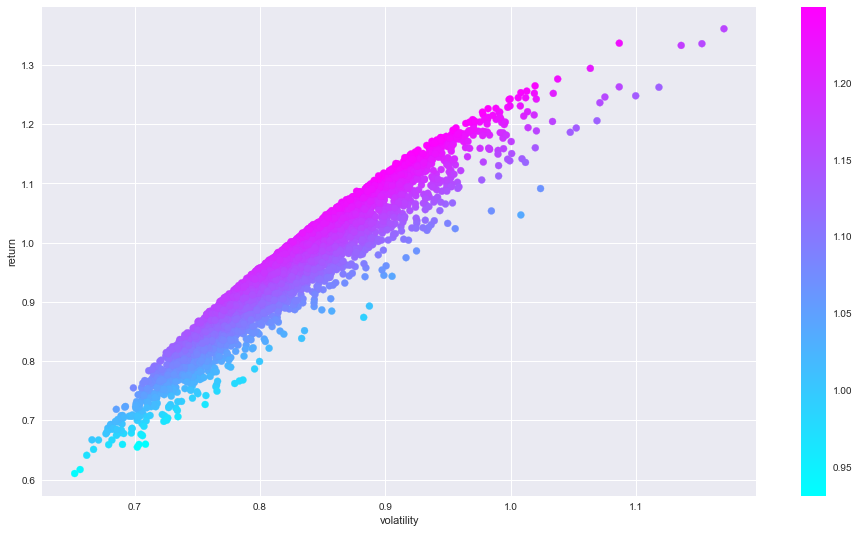

In [11]:
matplotlib.style.use('seaborn')

fig, ax = plt.subplots(figsize=(16,9))

ratios= rets/vols

sc= ax.scatter(vols, rets, c=ratios, marker='o', cmap='cool')
ax.set_xlabel('volatility')
ax.set_ylabel('return')
plt.colorbar(sc)

#### Compute and optimize the sharpe ratio

In [12]:
def min_sharpe(weight, df1):
    ret=compute_return(weight, log_ret2)
    vol=compute_vol(weight,log_ret2)
    return -(ret)/(vol)

sum1= ({'type':'eq','fun': lambda x: np.sum(x)-1})

positive = ((0,1), (0,1), (0,1), (0,1), (0,1))

weight = np.random.rand(asset)
weight= weight/np.sum(weight)

optimal = scpo.minimize(min_sharpe, weight, method='SLSQP', bounds=positive, constraints= sum1, args=log_ret2)

In [13]:
op_weight= optimal['x']

In [14]:
optimization_crypto= pd.DataFrame(optimal)

In [15]:
SR_crypto = optimization_crypto.loc[0:'fun']

#### Optimal  crypto portfolio
We optimized our crypto positions, generating weights in order to maximize the sharpe ratio. Moreover our results are consistent with the correlation analysis. Indeed both BTC and BNB have been exluded from the portfolio.

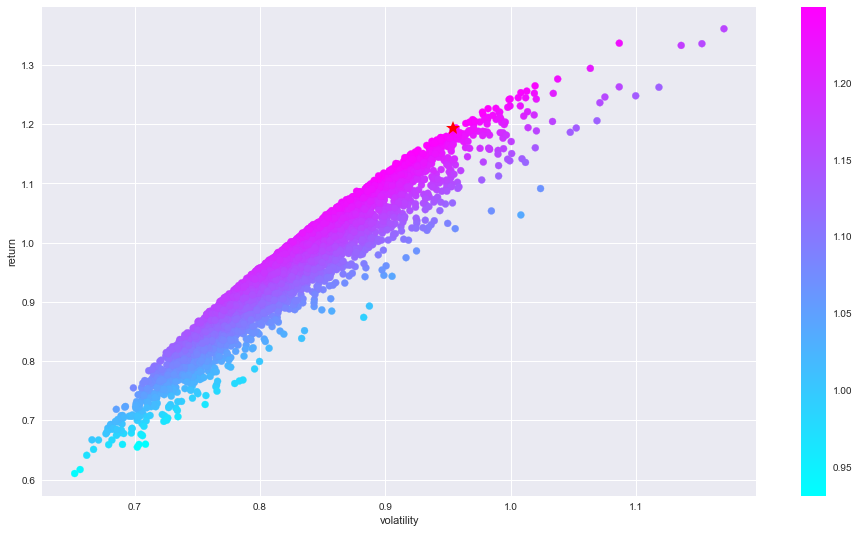

In [16]:
ax.plot(compute_vol(op_weight, log_ret2), compute_return(op_weight, log_ret2), 'r*', markersize=15.0)

fig

In [17]:
crypto_positions=pd.DataFrame(op_weight).rename(columns={0:'weights'})
crypto_positions= crypto_positions.rename(index={0:'BTC-USD',1:'ETH-USD',2:'BNB-USD',3:'LUNA1-USD',4:'MATIC-USD'})
#crypto_positions.loc[crypto_positions['weights']>0.01,:]

#we removed BTC and BNB because the optimal weights after the analysis was 0
crypto_positions_clean=crypto_positions.loc[crypto_positions['weights']>0,:]
crypto_positions_clean

,weights
ETH-USD,0.294923
LUNA1-USD,0.316529
MATIC-USD,0.388548


#### Determine our stock portfolio mean return

In [18]:
logret_mean_annualized=logret_mean*252
logret_m_clean= logret_mean_annualized.drop('BTC-USD').rename(columns={0:'annualized log ret'})
logret_m_clean2= logret_m_clean.drop('BNB-USD')
logret_m_clean2

,annualized log ret
ETH-USD,0.802507
LUNA1-USD,1.179407
MATIC-USD,1.503726


In [19]:
total_return = pd.np.multiply(crypto_positions_clean, logret_m_clean2).rename(columns={'weights':'Mean returns'})
crypto_total_ret=total_return.sum()
crypto_total_ret

/var/folders/77/ys_vtmc52wj63p97s4j17t3r0000gn/T/ipykernel_3133/1199656963.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  total_return = pd.np.multiply(crypto_positions_clean, logret_m_clean2).rename(columns={'weights':'Mean returns'})
/var/folders/77/ys_vtmc52wj63p97s4j17t3r0000gn/T/ipykernel_3133/1199656963.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  total_return = pd.np.multiply(crypto_positions_clean, logret_m_clean2

Mean returns    1.194264
dtype: float64

-----
# Stock portfolio

1. Stocks - Data: load and describe
2. Stocks - Data processing and exploratory analysis
3. Stocks - Portfolio construction
-----

## 1.Stocks - Data: load and describe

- Load tickers with esg score
- Remove 20% of the tickers with lowest esg score 
- Remove delisted companies 
- Get closing price from cleaned data
---

#### Load tickers with esg score 

Differently from the crypto, we retrieved data from Refinitiv Datastream, which allowed us to get ESG scores for the selected assets. As said before, our non-alternative assets include a universe of stocks which are part of the SP500. Firstly, we upload the whole sp500 universe with the respective 2020 ESG score for each component.

- Get tickers withe their ESG scores
- Save as a CSV file on our laptop
- Import the CSV file in Jupyter
- Transpose the data (for the quantile code)
- Rename the column from 0 to 'Score'
- Print the dataframe

In [20]:
df_esg = pd.read_csv('/Users/matteomamino/Desktop/Python/Group project/ESG-Score.csv', sep=";", index_col=None)
df2_esg = df_esg.T.rename(columns={0:'Score'})

#### Remove 20% of the tickers with lowest esg score 

- We dropped the bottom 20% stocks in terms of ESG score, with respect to the value reported in 2020 using the quantile function.

In [21]:
clean_esg = df2_esg[df2_esg.Score > df2_esg.Score.quantile(.2)]

#### Remove delisted companies
- Convert the remaining tickers into a list, with the aim of creating a new "cleaned" sample
- Delete the delisted tickers (BF.B)

In [22]:
ticker_esg = list(clean_esg.index)

ticker_esg.remove('BF.B')

tick_esg = repr(ticker_esg).replace(' ', '')

In [23]:
tickers_s = ['AMZN','ABT','AES','IBM','AMD','ADBE','ARE','APD','BXP','ALL','HON','AMGN','HES','AXP','AEP','AFL','AIG','ADI','VLO','CMCSA','ANSS','AAPL','AMAT','ALB','ADM','PNW','ADSK','ADP','AZO','AVY','BLL','BAX','BDX','VZ','WRB','BBY','YUM','FE','BA','RHI','BSX','MTD','BMY','OKE','AVB','URI','SRE','FDX','APH','CPB','CAH','CAT','JPM','CHD','CTAS','CSCO','CLX','KO','CL','MAR','CMA','NRG','CAG','ED','COO','GLW','SEE','CMI','DHR','MCO','CTSH','TGT','DE','MS','RSG','DIS','DLTR','DOV','OMC','DTE','DRI','BAC','C','EMN','CDNS','ECL','PKI','CRM','EMR','ESS','ETR','EQR','EL','EXPD','XOM','FMC','NEE','FDS','AIZ','FITB','BEN','FCX','AJG','GD','GIS','GILD','IT','MCK','NVDA','GWW','HAL','GS','HAS','HSIC','HSY','FFIV','JNPR','HOLX','HD','HRL','HUM','JBHT','HBAN','BIIB','IEX','ITW','INTU','IDXX','INTC','IFF','IP','IPG','J','INCY','JNJ','HIG','KLAC','DVN','K','KEY','KIM','KMB','KR','LRCX','PKG','AKAM','LLY','LNC','UPS','A','LMT','CCL','LOW','D','MGM','MKC','MCD','RE','EW','HST','MMC','MAS','MET','ATVI','CVS','LH','MSFT','MU','MAA','MCHP','MMM','MHK','CRL','ILMN','XEL','F','NTAP','NWL','NEM','NKE','NDSN','NSC','NI','NTRS','NOC','WFC','COF','OXY','ORCL','PCAR','PH','ALGN','PPL','PEP','PFE','COP','PXD','MO','PNC','PPG','IPGP','COST','DGX','PG','PEG','PHM','QCOM','O','REG','UDR','REGN','RMD','USB','ROP','ROK','RCL','TRV','FIS','MRK','SLB','SCHW','ZBH','ABC','PFG','SHW','CNC','SPG','AOS','PRU','AAP','EIX','SO','LUV','T','CVX','STT','SBUX','PSA','SYK','SNPS','SYY','ISRG','TFX','TXN','TXT','TMO','DVA','TSCO','TYL','TSN','MRO','UNP','UNH','VTR','VFC','VRTX','VNO','WMT','WM','WAT','WST','SJM','WDC','WAB','WY','WHR','WYNN','NDAQ','WMB','TJX','ZION','RF','DPZ','DLR','MKTX','CE','TAP','CF','AMP','CMG','MA','BR','DAL','DFS','BK','ULTA','IVZ','MSCI','PM','V','AWK','CB','MPC','FBHS','MOS','KMI','XYL','SWK','LYB','PVH','GRMN','PLD','EPAM','ACN','HCA','VRSK','RL','NXPI','CBOE','FTNT','MSI','TSLA','TEL','GM','CBRE','APTV','PSX','AMT','FB','DUK','FANG','NOW','MDLZ','ETN','ABBV','TMUS','ZTS','NCLH','CDW','AAL','WTW','BKR','LW','IQV','LDOS','AVGO','TPR','ALLE','ICE','MRNA','CI','DOW','AMCR','PEAK','FOXA','NLOK','DD','CARR','OTIS','CTVA','LHX','TT','HWM','TFC','PARA','STX','GE','PNR','RTX','LUMN','VTRS','ANET','FRT','APA','BBWI','CTLT','SYF','CFG','KEYS','QRVO','TECH','ANTM','CCI','MDT','WBA','IRM','EQIX','ES','SEDG','NLSN','ETSY','JCI','XRAY','WRK','KHC','SPGI','HLT','GOOGL','WELL','HPE','PYPL','HPQ','DXC','WEC','LIN','SBAC']

#### Get closing price from cleaned data
In this step we retrieved data of the "cleaned" sample from the yahoo finance API, which allowed us to collect prices from 01/01/2015 until 31/12/2021.

In [24]:
dfs_s=[]
col = ['adjclose']

for ticker in tickers_s:
    frame_s = si.get_data(ticker, start_date = '01/01/2015', end_date = '31/12/2021')[col].rename(columns={'adjclose':ticker})
    dfs_s.append(frame_s)
    
df_s = pd.concat(dfs_s,axis = 1)

----
## 2.Stocks - Data processing and exploratory analysis

- Dropped all stocks that did not have a reported price as of 01/01/2015.
- Get new dataframe of returns 
- Get new dataframe of log returns 
- Statistical test of means equal to 0 
- Retrive data for the selected tickers
- Provide a statistic summary
-----

#### Dropped all stocks that did not have a reported price as of 01/01/2015
Here we applied the second filter to the stock sample. Specifically, we dropped all the stocks that did not have a reported price as of 01/01/2015 (14 stocks). 

In [25]:
df_clean = df_s.dropna(axis=1, how='any')

#### Get new dataframe of returns

In [26]:
ret_s = df_clean.pct_change(1).dropna()

#### Get new dataframe of log returns

In [27]:
log_ret_s = np.log(ret_s+1)
log_ret_fin1 = log_ret_s.dropna()

#### Statistical test of means equal to 0 
- As a third filter of our analysis, we decided to consider only the stocks which have logaritmich returns, on average,  statistically different from zero, with a confidence level of 99% ($a$ = 1%)
- To do so, we dropped the stocks with a p-value greater than 0.1

In [28]:
mean_test = {}

tick_mean = ['AMZN','ABT','AES','IBM','AMD','ADBE','ARE','APD','BXP','ALL','HON','AMGN','HES','AXP','AEP','AFL','AIG','ADI','VLO','CMCSA','ANSS','AAPL','AMAT','ALB','ADM','PNW','ADSK','ADP','AZO','AVY','BLL','BAX','BDX','VZ','WRB','BBY','YUM','FE','BA','RHI','BSX','MTD','BMY','OKE','AVB','URI','SRE','FDX','APH','CPB','CAH','CAT','JPM','CHD','CTAS','CSCO','CLX','KO','CL','MAR','CMA','NRG','CAG','ED','COO','GLW','SEE','CMI','DHR','MCO','CTSH','TGT','DE','MS','RSG','DIS','DLTR','DOV','OMC','DTE','DRI','BAC','C','EMN','CDNS','ECL','PKI','CRM','EMR','ESS','ETR','EQR','EL','EXPD','XOM','FMC','NEE','FDS','AIZ','FITB','BEN','FCX','AJG','GD','GIS','GILD','IT','MCK','NVDA','GWW','HAL','GS','HAS','HSIC','HSY','FFIV','JNPR','HOLX','HD','HRL','HUM','JBHT','HBAN','BIIB','IEX','ITW','INTU','IDXX','INTC','IFF','IP','IPG','J','INCY','JNJ','HIG','KLAC','DVN','K','KEY','KIM','KMB','KR','LRCX','PKG','AKAM','LLY','LNC','UPS','A','LMT','CCL','LOW','D','MGM','MKC','MCD','RE','EW','HST','MMC','MAS','MET','ATVI','CVS','LH','MSFT','MU','MAA','MCHP','MMM','MHK','CRL','ILMN','XEL','F','NTAP','NWL','NEM','NKE','NDSN','NSC','NI','NTRS','NOC','WFC','COF','OXY','ORCL','PCAR','PH','ALGN','PPL','PEP','PFE','COP','PXD','MO','PNC','PPG','IPGP','COST','DGX','PG','PEG','PHM','QCOM','O','REG','UDR','REGN','RMD','USB','ROP','ROK','RCL','TRV','FIS','MRK','SLB','SCHW','ZBH','ABC','PFG','SHW','CNC','SPG','AOS','PRU','AAP','EIX','SO','LUV','T','CVX','STT','SBUX','PSA','SYK','SNPS','SYY','ISRG','TFX','TXN','TXT','TMO','DVA','TSCO','TYL','TSN','MRO','UNP','UNH','VTR','VFC','VRTX','VNO','WMT','WM','WAT','WST','SJM','WDC','WAB','WY','WHR','WYNN','NDAQ','WMB','TJX','ZION','RF','DPZ','DLR','MKTX','CE','TAP','CF','AMP','CMG','MA','BR','DAL','DFS','BK','ULTA','IVZ','MSCI','PM','V','AWK','CB','MPC','FBHS','MOS','KMI','XYL','SWK','LYB','PVH','GRMN','PLD','EPAM','ACN','HCA','VRSK','RL','NXPI','CBOE','FTNT','MSI','TSLA','TEL','GM','CBRE','APTV','PSX','AMT','FB','DUK','FANG','NOW','MDLZ','ETN','ABBV','TMUS','WBA','IRM','EQIX','ES','NLSN','JCI','XRAY','SPGI','HLT','GOOGL','WELL','HPQ','DXC','WEC','LIN','SBAC']
stock = np.zeros(len(log_ret_fin1.AMZN))

for ticker in tick_mean:
    output = sms.weightstats.ttest_ind(log_ret_fin1[ticker],stock,value=0)
    mean_test[ticker] = output

In [29]:
mean_test_s = pd.DataFrame(mean_test)

mean_test_s2 = pd.DataFrame(mean_test_s.loc[1,:])

mean_test_s3 = mean_test_s2.loc[mean_test_s2[1]<0.1,:]

- Afterwards, we create a list with the final tickers which will be included in our stock portoflio

In [30]:
selected_tickers = list(mean_test_s3.index)

tick = repr(selected_tickers).replace(' ', '')

fin_tickers = ['AMZN','ABT','AMD','ADBE','ARE','ANSS','AAPL','AMAT','ADP','AZO','AVY','YUM','MTD','APH','CHD','CTAS','DHR','MCO','TGT','DE','RSG','DOV','CDNS','PKI','CRM','EL','EXPD','NEE','FDS','AJG','IT','NVDA','HD','IEX','ITW','INTU','IDXX','KLAC','LRCX','LLY','A','LOW','MKC','MCD','EW','MMC','MAS','MSFT','MAA','CRL','NKE','NOC','ALGN','COST','RMD','ROP','ROK','SHW','AOS','SBUX','SYK','SNPS','ISRG','TXN','TMO','TYL','UNH','WM','WAT','WST','NDAQ','DPZ','DLR','MKTX','MA','BR','MSCI','V','AWK','XYL','GRMN','PLD','EPAM','ACN','VRSK','FTNT','MSI','TSLA','AMT','FB','NOW','TMUS','EQIX','SPGI','GOOGL','LIN','SBAC']

#### Retrive data for the selected tickers
- At this point, we used the yahoo finance API to retrieve prices of the select sample, which will be used to perfrom the last part of our analysis

In [31]:
dfs1_s=[]
col = ['adjclose']

for ticker in fin_tickers:
    frame1_s = si.get_data(ticker, start_date = '01/01/2015', end_date = '31/12/2021')[col].rename(columns={'adjclose':ticker})
    dfs1_s.append(frame1_s)

df_final2_s = pd.concat(dfs1_s,axis = 1)

#### Provide a statistic summary
- Subsequently we computed the respective returns, log returns, and annualized log returns

In [32]:
dfs2_stock=[]

for ticker in df_final2_s:
    frame2_stock = df_final2_s.pct_change(axis=0)
    dfs2_stock.append(frame2_stock)
    if ticker == 'AMZN':
        break
    
ret2_stock= pd.concat(dfs2_stock,axis=1).dropna()

log_ret2_stock=np.log(ret2_stock+1)
log_ret2_stock.index.name='date'
log_ret_mean_stock = log_ret2_stock.mean()
log_ret_mean_stock = pd.DataFrame(log_ret_mean_stock)
annualized_log_ret_mean_stock = log_ret_mean_stock*252
annualized_log_ret_mean_stock.describe().rename(columns={0:'statistics'})

,statistics
count,97.000000
mean,0.234297
std,0.078192
min,0.149021
25%,0.179576
50%,0.212774
75%,0.259680
max,0.588541


-----
## 3.Stocks - Portfolio construction
Our final part of the stock sample analysis regards the optimization of the portoflio with respect to the sharpe ratio with the aim of building the efficient fronteer. We consider only long positions. This analysis allowed us to maximise the return of our portfolio by taking into consideration past results. Specifically we analyzed returns in the period between 01/01/2015 and 31/12/2021.

- Compute annualized mean and annualized volatility
- Determine random weights
- Compute and optimize the sharpe ratio
- Determine our stock portfolio mean return
-----

#### Compute annualized mean and annualized volatility

In [33]:
def compute_return(weight, df_final2_s):
    mean= np.sum(df_final2_s.mean()*252*weight)
    return mean

def compute_vol(weight, df_final2_s):
    covar=df_final2_s.cov()*252
    var=weight.T@covar@weight
    vol=np.sqrt(var)
    return vol

#### Determine random weights

In [34]:
N=10000
asset=log_ret2_stock.shape[1]

rets=[]
vols=[]

np.random.seed(20)


for p in range (N):
    weight=np.random.random_sample(asset)
    weight /= np.sum(weight)
    ret=compute_return(weight, log_ret2_stock)
    rets.append(ret)
    vol= compute_vol(weight, log_ret2_stock)
    vols.append(vol)
    
rets= np.array(rets)
vols= np.array(vols)

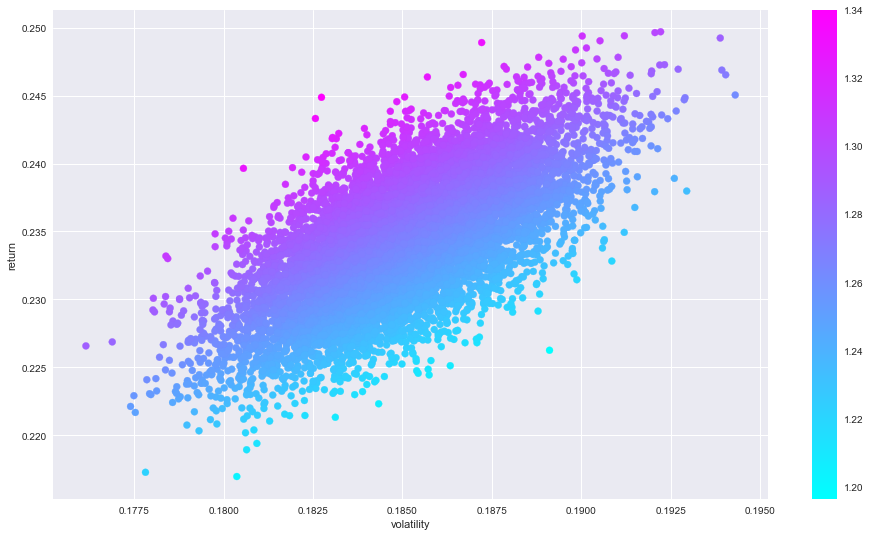

In [35]:
matplotlib.style.use('seaborn')

fig, ax = plt.subplots(figsize=(16,9))

ratios = rets/vols

sc = ax.scatter(vols, rets, c=ratios, marker='o', cmap='cool')
ax.set_xlabel('volatility')
ax.set_ylabel('return')
plt.colorbar(sc)

#### Compute and optimize the sharpe ratio

In [36]:
import scipy.optimize as scpo

def min_sharpe(weight,df_final2_s):
    ret = compute_return(weight, log_ret2_stock)
    vol = compute_vol(weight, log_ret2_stock)
    return -(ret)/(vol)

sum1 = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

positive = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1))

weight = np.random.rand(asset)
weight = weight/np.sum(weight)

optimal = scpo.minimize(min_sharpe, weight, method='SLSQP', bounds=positive, constraints=sum1, args=log_ret2_stock)

In [37]:
op_weight= optimal['x']

In [38]:
optimization_stocks= pd.DataFrame(optimal)

In [39]:
SR_stocks= optimization_stocks.loc[0,'fun']

#### Determine stock portfolio mean return
- Our analysis ends with the computation of the stock portfolio return, which is consistent with the weights and the log returns of each component of the selected sample

In [40]:
weights = pd.DataFrame(op_weight).rename(columns={0:'weights'})
tickers_fin = pd.DataFrame(fin_tickers).rename(columns={0:'ticker'})
port = pd.concat([weights,tickers_fin], axis=1, join='inner') 
portf = port.set_index('ticker')
portfolio_s = pd.np.multiply(portf,annualized_log_ret_mean_stock).rename(columns={'weights':'Mean returns'})
stock_total_ret = portfolio_s.sum()
stock_total_ret

/var/folders/77/ys_vtmc52wj63p97s4j17t3r0000gn/T/ipykernel_3133/4266704481.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  portfolio_s = pd.np.multiply(portf,annualized_log_ret_mean_stock).rename(columns={'weights':'Mean returns'})
/var/folders/77/ys_vtmc52wj63p97s4j17t3r0000gn/T/ipykernel_3133/4266704481.py:5: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  portfolio_s = pd.np.multiply(portf,annualized_log_ret_mean_stock).rename(c

Mean returns    0.322584
dtype: float64

## 4.Stocks and Crypto - Portfolio analysis

In this section we will combine the stock and crypto portfolio. The respective weights are 90% for stocks and 10% for crypto, with the aim of exploiting crypto returns while hedging with stock stability.

- Portfolio annual return
- Stock weighted returns
- Crypto weighted returns
- Portfolio weighted returns
- Cumulative returns Stock & Crypto portfolio, SP500 and Stock portfolio

#### Portfolio annual return

In [41]:
mix_portfolio = (crypto_total_ret*0.1)+(stock_total_ret*0.9)
mix_portfolio

Mean returns    0.409752
dtype: float64

#### Stock weighted returns

In order to compute the stock weighted returns and subsequently compare them with the crypto related part, we performed a resample based on business days. To make the comparison accurate, the stock timeframe was adjusted consistently with the crypto timeframe. 

In [42]:
portf_array=np.array(portf.T)
weightedret_s= log_ret2_stock.mul(portf_array, axis=1)
weighted_logret_stock_sum=pd.DataFrame(weightedret_s.sum(axis=1)).rename(columns={0:'weighted_ret'})
weighted_logret_stock_sum_balanced= weighted_logret_stock_sum*0.9
weighted_logret_stock_sum_balanced
df = weighted_logret_stock_sum_balanced.loc[weighted_logret_stock_sum_balanced.index > '2019/07/26'].copy()
df_bdays = df.resample('B').sum()

#### Crypto weighted returns
The cryto market is open also during weekends and festivity, therefore we performed a resample based on business days. 

In [43]:
crypto_positions_array=np.array(crypto_positions.T)
weightedret_c=log_ret2.mul(crypto_positions_array, axis=1)
weighted_logret_crypto_sum=pd.DataFrame(weightedret_c.sum(axis=1)).rename(columns={0:'weighted_ret'})
weighted_logret_crypto_sum_balanced= weighted_logret_crypto_sum*0.1
weighted_logret_crypto_sum_balanced_bday = weighted_logret_crypto_sum_balanced.resample('B').sum()
weighted_logret_crypto_sum_balanced_bday.iloc[1:,:]

,weighted_ret
2019-07-29,-0.000627
2019-07-30,0.000253
2019-07-31,0.000736
2019-08-01,-0.003038
2019-08-02,-0.001733
...,...
2021-12-24,0.004390
2021-12-27,-0.005275
2021-12-28,-0.007124
2021-12-29,-0.002299


#### Portfolio weighted returns
We retrieved the SP500 data in order to use it as benchmark for our portfolio.

In [44]:
bday_ret_mixedport=weighted_logret_crypto_sum_balanced_bday+df_bdays
bday_ret_mixedport=bday_ret_mixedport.dropna()

In [45]:
bday_ret_mixedport['CumulRet_portfolio_stock&crypto'] = np.exp(bday_ret_mixedport['weighted_ret'].cumsum())

In [46]:
sp500=si.get_data('^GSPC')['adjclose']
sp500=pd.DataFrame(sp500)
sp500= sp500.loc[sp500.index > '2019/07/26'].copy()
sp500= sp500.loc[sp500.index <'2021/12/31'].copy()
sp500_ret = sp500.pct_change(axis=0).dropna()
sp500_logret=np.log(sp500_ret+1).rename(columns={'adjclose':'log_ret'})
sp500_logret['CumulRet_SP'] = np.exp(sp500_logret['log_ret'].cumsum())

#### Cumulative returns Stock & Crypto portfolio, SP500 and Stock portfolio

In this part we wanted to highlight the effects of sharpe ratio optimization on our portfolio performances. This is shown in the chart below. The optimization is made clear by the difference between the SP500 cumulative returns (green line) and our Stock portfolio cumulative returns (red line).

The 10% crypto position allowed the portfolio to overperform the benchmark during the selected time horizon.

In [47]:
bday_ret_mixedport['CumulRet_portfolio_stock&crypto'] = np.exp(bday_ret_mixedport['weighted_ret'].cumsum())

weighted_logret_stock_sum2=weighted_logret_stock_sum.loc[weighted_logret_stock_sum.index > '2019/07/26'].copy()
weighted_logret_stock_sum2.resample('B').sum()
weighted_logret_stock_sum2['CumulRet_Stock'] = np.exp(weighted_logret_stock_sum2['weighted_ret'].cumsum())
stock_ready=weighted_logret_stock_sum2[['CumulRet_Stock']]

portfolio_ready=bday_ret_mixedport[['CumulRet_portfolio_stock&crypto']]
SP_ready=sp500_logret[['CumulRet_SP']]
SP_ready=SP_ready.resample('B').mean()

<AxesSubplot:>

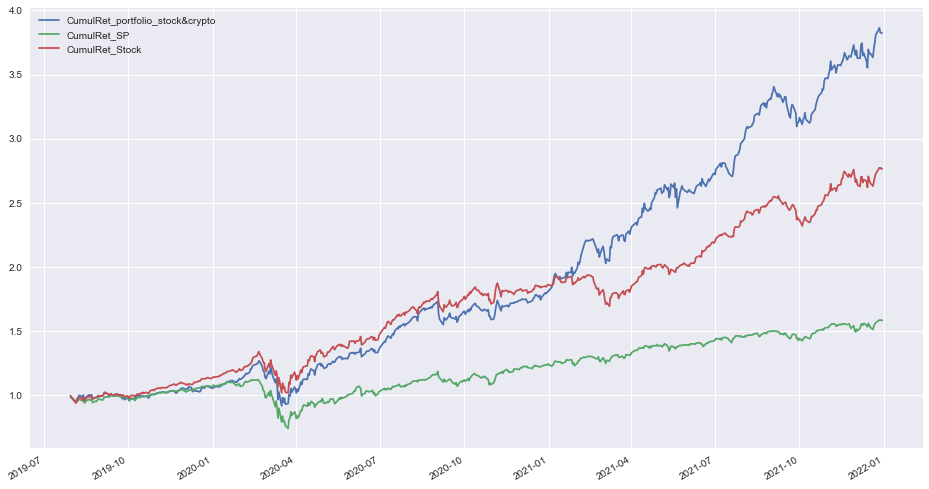

In [48]:
backtest = pd.concat([portfolio_ready, SP_ready, stock_ready], axis=1, join='inner')
backtest.loc[:,['CumulRet_portfolio_stock&crypto','CumulRet_SP','CumulRet_Stock']].plot(figsize=(16,9))

----
## Questions
1. Are there consistent patterns to predict asset returns ?

No, we don't think that there are consistent patterns to predict asset returns. There are some patterns that can be analyzed in order to give to the analysis more context and precision. From the technical analysis to the fondamental analysis, all the data and computations can be used to strengthen a possible future forecast, but we would say that it's impossible to really predict with great precision asset returns. We decided to base our analysis on sharpe ratio optimizaion, analyzing past returns in order to create the right context for our data. We focused on basing our analysis on datasets as clean as possible in order to avoid any sort of bias and noise. This is the best way for us to conduct a right and precise analysis, that than can be interpreted with further analysis.


2. Inclusion of cryptocurrencies is more likely to increase or decrease performance ?

As we can see from the chart above, the crypto positions really helped the portfolio to overperform both the benchmark and the stock portfolio. It is also clear that the portfolio benefits from the high volatility of this type of asset during periods of growth, but on the other hand this type of volatility hardly affects the portfolio returns during harder times. We also believe that an accurate selection is required in order to avoid exposure to projects without good fundamentals. That's why we decided to filter our crypto selection with data from each crypto's DeFi ecosystem. We believed that the DeFi ecosystem is one of the best valuation metrics to use when evaluating a cryptocurrency, because it perfectly describe how and if a crypto project has a real intrinsic value.